#### Let's try basic univariate LSTM modeling

#### We'll do univariate single step forecasting
* We'll use the same grain to perform univariate multi-step forecasting.
* We know that the size of train data for the above grain is 909 and the size of validation data is 102.
* We'll use the train data to create sequences and predict the next-step o/p.
* We'll check which window has performed the best.
* We'll use that window-size to decide the o/p.
* For the date for which the prediction has to be made, check if the prior window-size dates are available or not. If not then the window has to be created(using history as well as available predictions) and it should be given to the model for prediction.

In [1]:
import pandas as pd
import numpy as np

In [2]:
train_weather_df = pd.read_csv('train_weather_df.csv').drop(columns = ['Unnamed: 0'])

In [3]:
train_weather_df.head()

,date,store_nbr,item_nbr,units,grain,day,wday,year,month,week,...,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,codesum_rev,extreme_weather,mild_weather
0,2012-01-01,15,45,108,15_45,1,6,2012,1,52,...,-201.753454,0.0,24.60,30.59,2.5,16.0,6.1,"['SN', 'BR']",0,0
1,2012-01-02,15,45,160,15_45,2,0,2012,1,1,...,-201.753454,0.0,24.55,30.54,6.1,16.0,6.8,"['SN', 'BR']",0,0
2,2012-01-03,15,45,128,15_45,3,1,2012,1,1,...,-201.753454,0.0,24.40,30.23,2.9,21.0,6.3,"['SN', 'BR']",0,0
3,2012-01-04,15,45,100,15_45,4,2,2012,1,1,...,-201.753454,0.0,24.49,30.36,5.5,19.0,6.1,"['SN', 'BR']",0,0
4,2012-01-05,15,45,103,15_45,5,3,2012,1,1,...,-201.753454,0.0,24.26,30.04,4.2,21.0,5.0,"['SN', 'BR']",0,0


In [4]:
from utilities.utility import split_dataset, calc_rmsle

In [5]:
train_x, train_y, val_x, val_y = split_dataset(train_weather_df[['grain','units']])

In [128]:
train_data = pd.read_csv('../csv_files/train_data.csv')
val_data = pd.read_csv('../csv_files/val_data.csv')

In [129]:
train_x, train_y, val_x, val_y = split_dataset(train_data[['grain','units']])

#### Let's create a sequence of size 20 with it's next value as output

In [130]:
def create_lstm_ip_seq(inp_seq, window_seq):
    new_ip_seq = []
    new_op_seq = []
    start_index = 0
    end_index = len(inp_seq)-window_seq
    for i in range(0,end_index):
        ip_sequence = np.array(inp_seq.iloc[i:i+window_seq].values)
        op = inp_seq.iloc[i+window_seq]
        new_ip_seq.append(ip_sequence)
        new_op_seq.append(op)

    new_ip_seq = np.array(new_ip_seq)
    new_op_seq = np.array(new_op_seq)
    print("Shape of new train_seq : ",new_ip_seq.shape)
    print("Shape of new op_seq : ",new_op_seq.shape)
    return new_ip_seq, new_op_seq

In [131]:
new_train_ip_seq, new_train_out_seq = create_lstm_ip_seq(train_y,7)
new_val_ip_seq, new_val_out_seq = create_lstm_ip_seq(val_y,7)

Shape of new train_seq :  (3738251, 7)
Shape of new op_seq :  (3738251,)
Shape of new train_seq :  (415355, 7)
Shape of new op_seq :  (415355,)


In [132]:
import tensorflow as tf

In [133]:
BATCH_SIZE = 256 # bacth size in batch-SGD/variants
BUFFER_SIZE = 10000 # for shuffling the dataset

train_univariate = tf.data.Dataset.from_tensor_slices((new_train_ip_seq, new_train_out_seq))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
#https://www.tensorflow.org/api_docs/python/tf/data/Dataset#repeat

val_univariate = tf.data.Dataset.from_tensor_slices((new_val_ip_seq, new_val_out_seq))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [134]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=(new_train_ip_seq.shape[1],1)),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='msle')

In [135]:
STEPS_PER_EPOCH = 200
EPOCHS =10

# https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit
simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=STEPS_PER_EPOCH,
                      validation_data=val_univariate,
                      validation_steps = 50)

Epoch 1/10
200/200 [==============================] - 2s 6ms/step - loss: 0.2492 - val_loss: 0.0000e+00
Epoch 2/10
200/200 [==============================] - 1s 4ms/step - loss: 0.2323 - val_loss: 0.0000e+00
Epoch 3/10
200/200 [==============================] - 1s 4ms/step - loss: 0.4065 - val_loss: 0.0000e+00
Epoch 4/10
200/200 [==============================] - 1s 4ms/step - loss: 0.2493 - val_loss: 0.0000e+00
Epoch 5/10
200/200 [==============================] - 1s 4ms/step - loss: 0.2768 - val_loss: 0.0000e+00
Epoch 6/10
200/200 [==============================] - 1s 4ms/step - loss: 0.5238 - val_loss: 0.0000e+00
Epoch 7/10
200/200 [==============================] - 1s 4ms/step - loss: 0.2207 - val_loss: 0.0000e+00
Epoch 8/10
200/200 [==============================] - 1s 4ms/step - loss: 0.3251 - val_loss: 0.0000e+00
Epoch 9/10
200/200 [==============================] - 1s 4ms/step - loss: 0.2663 - val_loss: 0.0000e+00
Epoch 10/10
200/200 [==============================] - 1s 4ms/st

In [137]:
for i in range(10):
    pred = simple_lstm_model.predict(new_val_ip_seq[i].reshape(1,-1))[0][0]
    obs = new_val_out_seq[i]

1/1 [==============================] - 0s 18ms/step


In [138]:
import matplotlib.pyplot as plt
import seaborn as sns

In [139]:
def plot_observations_predictions(observations, predictions):
    plt.rc("figure", figsize=(25, 8))
    plt.rc("font", size=12)

    plt.plot(observations,color="blue",label='observations')
    plt.plot(predictions, color='red',label='predictions')
    plt.title("Plot of Predictions and Observed values")
    plt.legend(loc="upper right")
    plt.xlabel("time")
    plt.ylabel("units")
    
    plt.show()

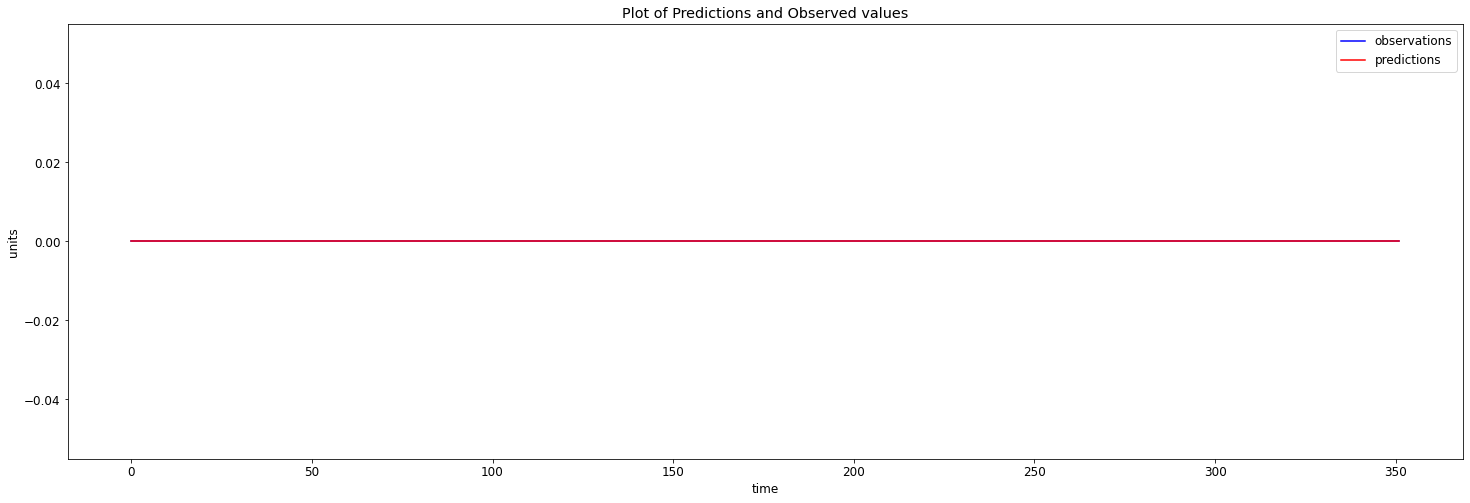

In [140]:
plot_observations_predictions(observations, predictions)

* We took a random sample for validation and turns out that the observations and predictions match.
* As we know about 95% of the units sold are 0.
* we'll now test it against the special grain or max_grain, the one which has maximum count of units sold.

#### Validating it against the 15th store 45th Item, the one with maximum count of units sold.

In [141]:
sp_train_x, sp_train_y, sp_val_x, sp_val_y = split_dataset(train_weather_df[['grain','units']])

In [143]:
sp_val_ip_seq, sp_val_out_seq = create_lstm_ip_seq(sp_val_y,7)

Shape of new train_seq :  (95, 7)
Shape of new op_seq :  (95,)


In [ ]:
predictions = []
observations = []
for i in range(len(sp_val_ip_seq)):
    pred = simple_lstm_model.predict(sp_val_ip_seq[i].reshape(1,-1))[0][0]
    obs = sp_val_out_seq[i]
    predictions.append(pred)
    observations.append(obs)

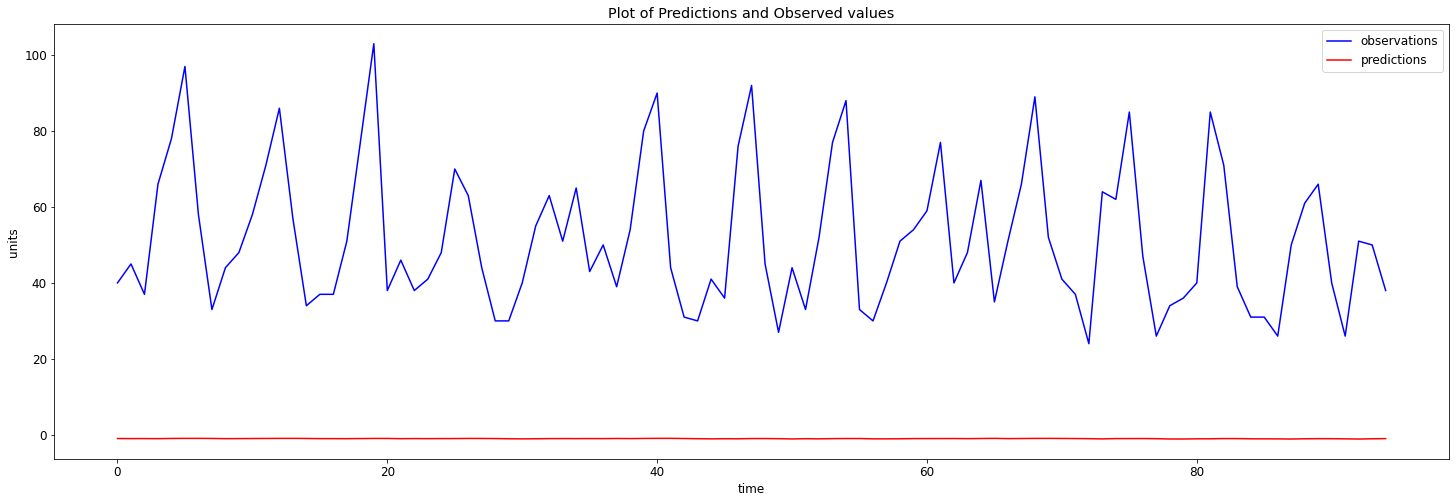

In [146]:
plot_observations_predictions(observations, predictions)

* The model hasn't learned properly, it has learned whatever is present for majority of the grains, which is zero in this case.

#### Let's form a dataset with grains having non-zero observations for each grain.
* We know there were 255 such grains.

In [147]:
train_data.shape

(4153620, 31)

In [148]:
val_data.shape

(463980, 31)

In [150]:
units_count_df = train_data[train_data['units']!=0].groupby(['grain'])['units'].count().reset_index()

In [154]:
print("Number of non zero grain observations : ",units_count_df.shape[0])

Number of non zero grain observations :  254


In [169]:
train_subs_df = train_data[train_data['grain'].isin(list(units_count_df['grain'].values))].drop(columns = ['Unnamed: 0']).reset_index()
val_subs_df = val_data[val_data['grain'].isin(list(units_count_df['grain'].values))].drop(columns = ['Unnamed: 0']).reset_index()

In [170]:
print("Number of rows in train data : ",train_subs_df.shape[0])
print("Number of rows in val data : ",val_subs_df.shape[0])

Number of rows in train data :  211434
Number of rows in val data :  23621


#### Let's create a function to train a simple LSTM model for univariate single step forecasting

In [178]:
train_ip_seq, train_out_seq = create_lstm_ip_seq(train_subs_df['units'],window_seq = 800)
val_ip_seq, val_out_seq = create_lstm_ip_seq(val_subs_df['units'],window_seq = 800)

Shape of new train_seq :  (210634, 800)
Shape of new op_seq :  (210634,)
Shape of new train_seq :  (22821, 800)
Shape of new op_seq :  (22821,)


In [179]:
def train_lstm_model(train_ip_seq, train_out_seq, val_ip_seq, val_out_seq, lstm_cells = 8, batch_size = 256,
                     buffer_size = 10000, epochs = 10, steps_per_epoch=200, validation_steps = 50):
    """
    Trains a simple lstm univariate forecasting model using the above inputs
    """
    
    train_univariate = tf.data.Dataset.from_tensor_slices((train_ip_seq, train_out_seq))
    train_univariate = train_univariate.cache().shuffle(buffer_size).batch(batch_size).repeat()
    
    val_univariate = tf.data.Dataset.from_tensor_slices((val_ip_seq, val_out_seq))
    val_univariate = val_univariate.batch(batch_size).repeat()
    
    simple_lstm_model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(lstm_cells, input_shape=(train_ip_seq.shape[1],1)),
        tf.keras.layers.Dense(1)
    ])

    simple_lstm_model.compile(optimizer='adam', loss='msle')
    simple_lstm_model.fit(train_univariate, epochs=epochs,
                      steps_per_epoch=steps_per_epoch,
                      validation_data=val_univariate,
                      validation_steps = validation_steps)
    
    return simple_lstm_model

In [180]:
def plot_validation_results(lstm_model, val_ip_seq, val_out_seq, validation_points = 10):
    observations = []
    predictions = []
    for i in range(validation_points):
        pred = simple_lstm_model.predict(val_ip_seq[i].reshape(1,-1))[0][0]
        obs = val_out_seq[i]
        predictions.append(pred)
        observations.append(obs)
    plot_observations_predictions(observations, predictions)

Epoch 1/10
200/200 [==============================] - 49s 237ms/step - loss: 3.5560 - val_loss: 2.5326
Epoch 2/10
200/200 [==============================] - 43s 215ms/step - loss: 2.1781 - val_loss: 1.6783
Epoch 3/10
200/200 [==============================] - 43s 213ms/step - loss: 1.3635 - val_loss: 1.4815
Epoch 4/10
200/200 [==============================] - 43s 213ms/step - loss: 1.9281 - val_loss: 1.3108
Epoch 5/10
200/200 [==============================] - 43s 216ms/step - loss: 1.5583 - val_loss: 1.1824
Epoch 6/10
200/200 [==============================] - 43s 214ms/step - loss: 1.2984 - val_loss: 1.0756
Epoch 7/10
200/200 [==============================] - 43s 213ms/step - loss: 0.9621 - val_loss: 1.0117
Epoch 8/10
200/200 [==============================] - 44s 221ms/step - loss: 1.4272 - val_loss: 0.9302
Epoch 9/10
200/200 [==============================] - 43s 213ms/step - loss: 1.1798 - val_loss: 0.8710
Epoch 10/10
1/1 [==============================] - 0s 48ms/step


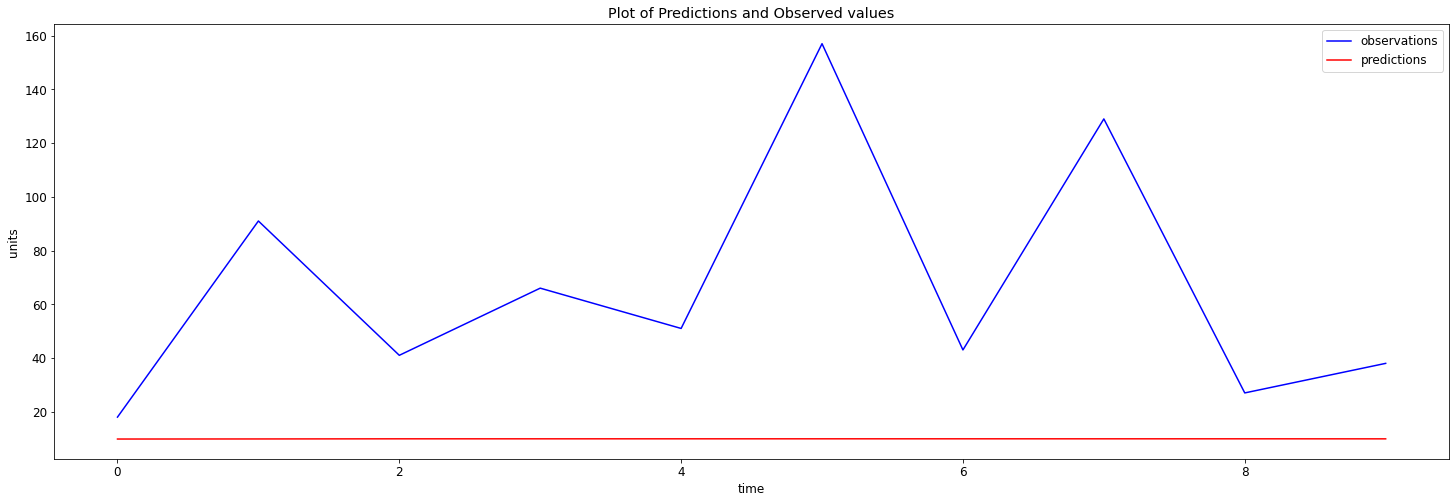

In [181]:
simple_lstm_model = train_lstm_model(train_ip_seq, train_out_seq, val_ip_seq, val_out_seq)

plot_validation_results(simple_lstm_model, val_ip_seq, val_out_seq)

### Conclusion
* So we tried three strategies here, but none of them worked.
* Hyper-params considered :window-sequence, lstm_cells, batch_size, buffer_size, epochs, steps_per_epoch.
* Single grain LSTM training with different hyper-params but didn't work.
* All grain LSTM training with different hyper-params, gave 0 for majority of the results as expected.
* All non-zero grains LSTM training with different hyper-params, gave unsatisfactory result.
* Maybe we are doing something wrong, need guidance in executing this.
